In [1]:
import Locate_Ice_Mosaic
from Locate_Ice_Mosaic import M3_Mosaic
from os import path as path
import os
import tifffile as tf

ice_pipe_folder = 'D:/Data/Ice_Pipeline_Out_6-14-23'
smooth_folder = path.join(ice_pipe_folder,'rfl_smooth')

in_dict = {}
prog,tot = 1,len(os.listdir(smooth_folder))
for file in os.listdir(smooth_folder):
    im = tf.imread(path.join(smooth_folder,file))
    in_dict.update({file[:-11]:im})
    print (f'\r{prog} of {tot} ({prog/tot:.1%})',end='\r')
    prog+=1

In [2]:
from importlib import reload
reload(Locate_Ice_Mosaic)
from Locate_Ice_Mosaic import M3_Mosaic

def load_tifs(pathList:list)->list:
    tif_list = []
    prog,tot = 1,len(pathList)
    for path in pathList:
        tif_list.append(tf.imread(path))
        print (f'\r{prog} of {tot} retrived. ({prog/tot:.0%})',end='\r')
        prog+=1
    return tif_list

print ('Select Analysis Folder:')
folderPath = 'D:/Data/Ice_Pipeline_Out_6-14-23'
all_rfl_paths = [os.path.join(folderPath,'rfl_cropped',i) for i in os.listdir(os.path.join(folderPath,'rfl_cropped'))]
all_loc_paths = [os.path.join(folderPath,'loc_cropped',i) for i in os.listdir(os.path.join(folderPath,'loc_cropped'))]
all_obs_paths = [os.path.join(folderPath,'obs_cropped',i) for i in os.listdir(os.path.join(folderPath,'obs_cropped'))]

with open(os.path.join(folderPath,'stampNames.txt')) as f:
    all_names = f.readlines()
all_names = [i[:-2] for i in all_names]

def batch_list(input:list,n:int)->list:
    return [input[i:i+n] for i in range(0,len(input),n)]


N = 5
batch_rfl_paths = batch_list(all_rfl_paths,N)
batch_loc_paths = batch_list(all_loc_paths,N)
batch_obs_paths = batch_list(all_obs_paths,N)
all_names_split = batch_list(all_names,N)
batch_keys = batch_list(tuple(in_dict.keys()),N)
batch_vals = batch_list(tuple(in_dict.values()),N)


prog,tot=0,len(all_rfl_paths)
for n in range(len(batch_rfl_paths)):
    print ('Retrieving RFL Tifs...')
    batch_rfl = load_tifs(batch_rfl_paths[n])
    print ('\nRetrieving LOC Tifs...')
    batch_loc = load_tifs(batch_loc_paths[n])
    print ('\nRetrieving OBS Tifs...')
    batch_obs = load_tifs(batch_obs_paths[n])
    batch_names = all_names_split[n]

    batch_dict = {key:val for key,val in zip(batch_keys[n],batch_vals[n])}
    print(batch_dict.keys())

    batchMosaic = M3_Mosaic(batch_rfl,batch_loc,batch_obs,batch_names,folderPath)
    prog = prog+len(batchMosaic.stampNames)
    print (f'\n-----Beginning Mosaic analysis of {len(batchMosaic.stampNames)} ({prog} of {tot})images-----')
    print ('locating ice...')
    allband_array = batchMosaic.locate_ice(inputImageDictionary=batch_dict)

    print ('\nRemoval from memory...')
    del batch_rfl,batch_loc,batch_obs

Select Analysis Folder:
Retrieving RFL Tifs...
5 of 5 retrived. (100%)
Retrieving LOC Tifs...
5 of 5 retrived. (100%)
Retrieving OBS Tifs...
dict_keys(['20090520t065048', '20090528t083319', '20090529t013507', '20090529t100749', '20090529t183825'])

-----Beginning Mosaic analysis of 5 (5 of 99)images-----
locating ice...
>>>Ice located in 29.1 seconds

Removal from memory...
Retrieving RFL Tifs...
5 of 5 retrived. (100%)
Retrieving LOC Tifs...
5 of 5 retrived. (100%)
Retrieving OBS Tifs...
dict_keys(['20090530t030925', '20090530t201123', '20090531t172712', '20090601t061442', '20090602t074711'])

-----Beginning Mosaic analysis of 5 (10 of 99)images-----
locating ice...
>>>Ice located in 17.7 seconds

Removal from memory...
Retrieving RFL Tifs...
5 of 5 retrived. (100%)
Retrieving LOC Tifs...
5 of 5 retrived. (100%)
Retrieving OBS Tifs...
dict_keys(['20090602t203342', '20090603t050442', '20090603t174502', '20090604t104552', '20090604t191631'])

-----Beginning Mosaic analysis of 5 (15 of 9

In [7]:
import os
from os import path as path
mypath = 'D:/Data/Ice_Pipeline_Out_6-2-23/spectral_angle_maps'
file_list = [i for i in os.listdir(mypath) if path.isfile(path.join(mypath,i))==True]
file_list

['20090520t065048_SAM.tif',
 '20090528t083319_SAM.tif',
 '20090529t013507_SAM.tif',
 '20090529t100749_SAM.tif',
 '20090529t183825_SAM.tif',
 '20090530t030925_SAM.tif',
 '20090530t201123_SAM.tif',
 '20090531t172712_SAM.tif',
 '20090601t061442_SAM.tif',
 '20090602t074711_SAM.tif',
 '20090602t203342_SAM.tif',
 '20090603t050442_SAM.tif',
 '20090603t174502_SAM.tif',
 '20090604t104552_SAM.tif',
 '20090604t191631_SAM.tif',
 '20090605t034701_SAM.tif',
 '20090605t163232_SAM.tif',
 '20090605t163636_SAM.tif',
 '20090606t010302_SAM.tif',
 '20090606t093322_SAM.tif',
 '20090607t110414_SAM.tif',
 '20090607t193433_SAM.tif',
 '20090608t040423_SAM.tif',
 '20090608t123433_SAM.tif',
 '20090609t095022_SAM.tif',
 '20090609t223544_SAM.tif',
 '20090610t070604_SAM.tif',
 '20090610t153615_SAM.tif',
 '20090610t154042_SAM.tif',
 '20090611t000633_SAM.tif',
 '20090611t083653_SAM.tif',
 '20090612t100753_SAM.tif',
 '20090612t183813_SAM.tif',
 '20090613t030843_SAM.tif',
 '20090613t113913_SAM.tif',
 '20090613t200943_SA

(3585, 304, 59)


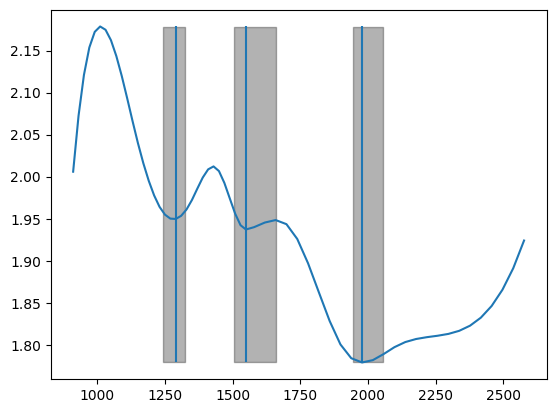

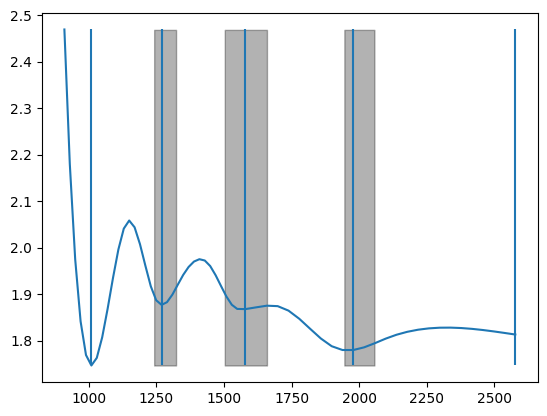

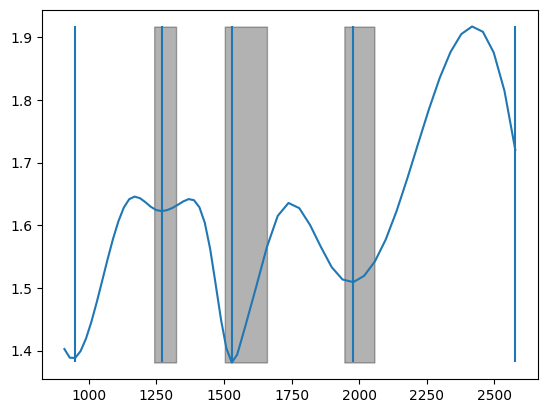

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
print (allband_array.shape)
df = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-2-23/bandInfo.csv')
wvl = df.iloc[:,2]
def plot_stuff(x,y):
    fig = plt.figure()
    test_spec = list(in_dict.values())[0][x,y,:]
    plt.plot(wvl,test_spec)
    plt.vlines(wvl[np.where(allband_array[x,y,:]==1)[0]],test_spec.min(),test_spec.max())
    plt.fill_betweenx(np.arange(test_spec.min(),test_spec.max(),0.001),1242,1323,color='k',alpha=0.3)
    plt.fill_betweenx(np.arange(test_spec.min(),test_spec.max(),0.001),1503,1659,color='k',alpha=0.3)
    plt.fill_betweenx(np.arange(test_spec.min(),test_spec.max(),0.001),1945,2056,color='k',alpha=0.3)
plot_stuff(0,98)
plot_stuff(0,101)
plot_stuff(3244,150)


44.855213019448456
45.507950938676636
45.507950938676636
44.855213019448456
43.236967102436815
43.989820821554176
43.989820821554176
40.87756225798143
50.25947602832627
50.25947602832627
40.87756225798143
43.989820821554176
43.179859392671574
49.27017355999539
43.78279355686042
50.25947602832627


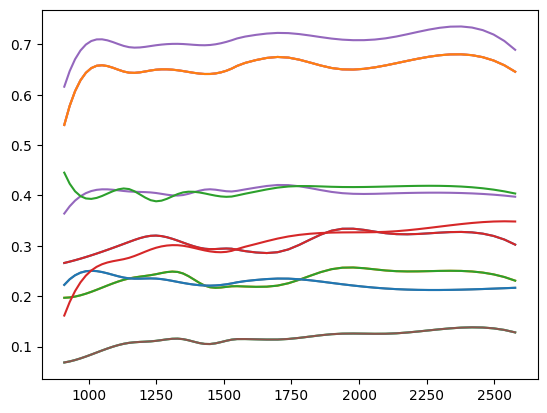

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from get_USGS_H2OFrost import get_USGS_H2OFrost
import numpy as np
df = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-2-23/sample_spectra.csv')
wvl_df = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-2-23/bandInfo.csv')
wvl = wvl_df.iloc[:,2]
_wvl,M = get_USGS_H2OFrost('D:/Data/USGS_Water_Ice')
for i in df.columns[1:]:
    I = np.array(df[i])
    plt.plot(wvl,I)
    #print (np.dot(I,M)/(np.linalg.norm(M)*np.linalg.norm(I)))
    print (180*(np.arccos(np.dot(df[i],M)/(np.linalg.norm(M)*np.linalg.norm(df[i])))/np.pi))

173, (0.02%)
(173, 59)


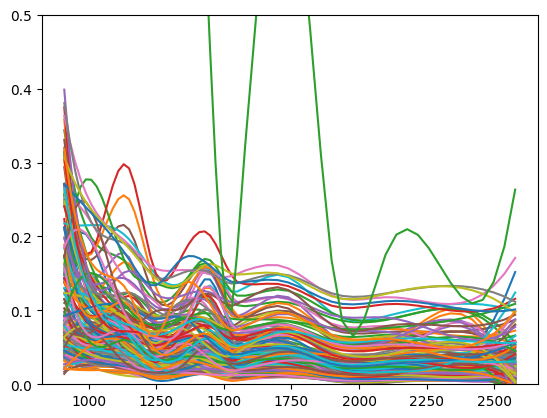

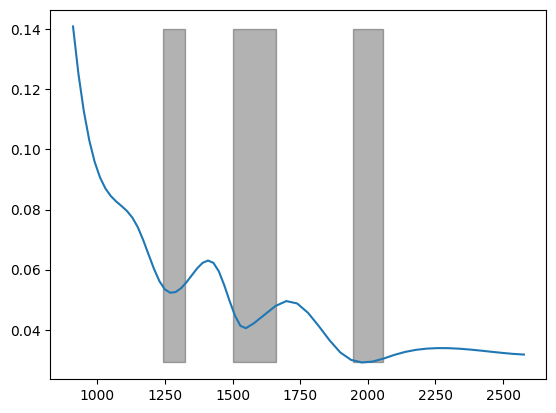

In [40]:
import tifffile as tf
smooth_im = tf.imread('D:/Data/Ice_Pipeline_Out_6-2-23/rfl_smooth/20090529t183825_smooth.tif')
df = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-2-23/detection_latlong.csv')
x,y = df['x'],df['y']
wvl_df = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-2-23/bandInfo.csv')
wvl = wvl_df.iloc[:,2]
_wvl,M = get_USGS_H2OFrost('D:/Data/USGS_Water_Ice')

avg_arr = np.zeros((0,59))

num = 0
for i,j in zip(x,y):
    I = smooth_im[i,j,:]
    plt.plot(wvl,I)
    #print (180*(np.arccos(np.dot(I,M)/(np.linalg.norm(M)*np.linalg.norm(I)))/np.pi))
    avg_arr = np.concatenate([avg_arr,I[np.newaxis,:]])
    num+=1
plt.ylim(0,0.5)
print (f'{num}, ({num/smooth_im[:,:,0].size:.2%})')
print (avg_arr.shape)
fig = plt.figure()
avg = np.mean(avg_arr,axis=0)
plt.plot(wvl,avg)
plt.fill_betweenx(np.arange(avg.min(),avg.max(),0.001),1242,1323,color='k',alpha=0.3)
plt.fill_betweenx(np.arange(avg.min(),avg.max(),0.001),1503,1659,color='k',alpha=0.3)
plt.fill_betweenx(np.arange(avg.min(),avg.max(),0.001),1945,2056,color='k',alpha=0.3)

(3333, 304, 2)
[[ 134676.5 -104529.2]
 [ 139184.5  -94104.5]
 [ 139466.2  -94668. ]
 [ 139748.   -92414. ]
 [ 140029.8  -92977.5]
 [ 140875.   -94104.5]
 [ 160034.  -171867.5]
 [ 199760.8 -207931.5]
 [ 202296.5 -203423.5]
 [ 204550.5 -212157.8]
 [ 207368.  -197506.8]]
2972 124 (3333, 304, 59)
2994 83 (3333, 304, 59)
2990 84 (3333, 304, 59)
2998 77 (3333, 304, 59)
2994 78 (3333, 304, 59)
2985 79 (3333, 304, 59)
2541 256 (3333, 304, 59)
2178 262 (3333, 304, 59)
2187 243 (3333, 304, 59)
2134 263 (3333, 304, 59)
2188 214 (3333, 304, 59)


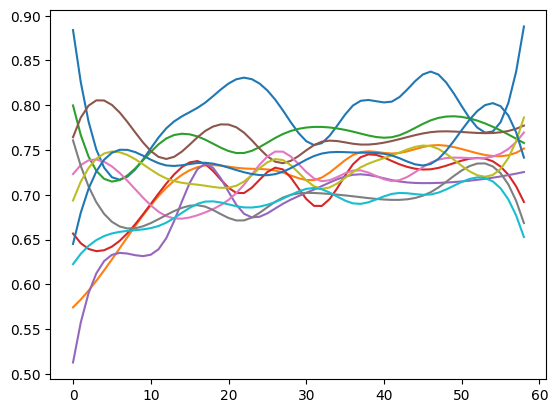

In [119]:
def stereo_project(lat:np.ndarray,long:np.ndarray)->np.ndarray:
    return np.array((2*1737400*np.tan(np.pi/4-np.pi*abs(lat/360))*np.sin(np.pi*long/180),\
            2*1737400*np.tan(np.pi/4-np.pi*abs(lat/360))*np.cos(np.pi*long/180)))
def stereo_project_float(lat:float,long:float)->tuple:
    return (2*1737400*np.tan(np.pi/4-np.pi*abs(lat/360))*np.sin(np.pi*long/180),\
            2*1737400*np.tan(np.pi/4-np.pi*abs(lat/360))*np.cos(np.pi*long/180))

smooth_im_backplane = tf.imread('D:/Data/Ice_Pipeline_Out_6-2-23/loc_cropped/m3g20090529t183825_loc_cropped.tif')
backplane_projected = np.moveaxis(stereo_project(smooth_im_backplane[:,:,1],smooth_im_backplane[:,:,0]),0,2)
print (backplane_projected.shape)

x_max,x_min,y_max,y_min = (backplane_projected[:,:,0].max(),backplane_projected[:,:,0].min(),backplane_projected[:,:,1].max(),backplane_projected[:,:,1].min())

with open('D:/Data/SP_IceLoc_280m.txt','r') as f:
    li_locations = f.readlines()
li_locations = [i[:-1] for i in li_locations]
li_locations = [i.split('\t') for i in li_locations]
li_locations = np.array(li_locations).astype(float)
li_locations_test = li_locations[np.where((li_locations[:,0]>x_min)&(li_locations[:,0]<x_max)&(li_locations[:,1]>y_min)&(li_locations[:,1]<y_max))]
print (li_locations_test)
fig = plt.figure()


prog,tot = 1,len(tuple(li_locations_test.T)[0])
mapped_coord_array = np.zeros((0,2))
for x,y in zip(*tuple(li_locations_test.T)):
    idx = (np.abs(backplane_projected[:,:,0]-x)+np.abs(backplane_projected[:,:,1]-y)).argmin()
    x_close,y_close = backplane_projected[:,:,0].flatten()[idx],backplane_projected[:,:,1].flatten()[idx]
    mapped_coord_array = np.concatenate([mapped_coord_array,np.array((x_close,y_close))[np.newaxis,:]])

for x,y in zip(mapped_coord_array[:,0],mapped_coord_array[:,1]):
    x_np,y_np = (np.where((backplane_projected[:,:,0]==x)&(backplane_projected[:,:,1]==y)))
    print (x_np[0],y_np[0],smooth_im.shape)
    plt.plot(smooth_im[x_np[0],y_np[0],:])


ORIG_MAX: 3.5693740844726562
ORIG_MIN: -0.11931402236223221

OBS_MAX: 164.74740600585938
OBS_MIN:26.795948028564453


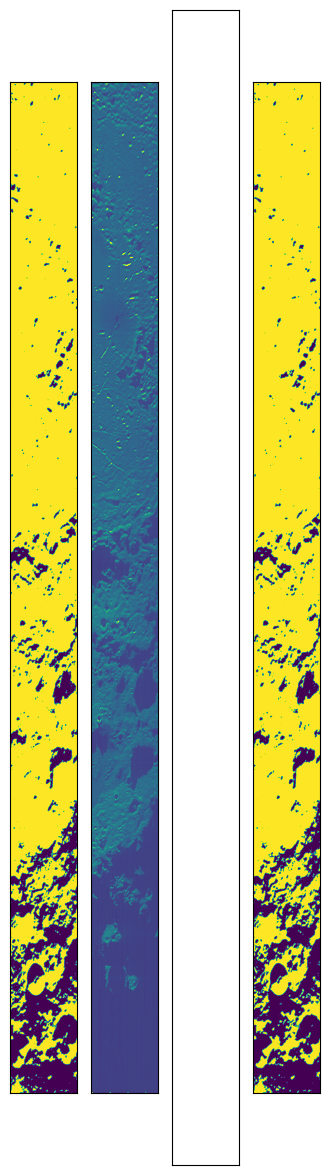

In [41]:
import os
import tifffile as tf
import numpy as np
import matplotlib.pyplot as plt

obs_im = tf.imread('D:/Data/Ice_Pipeline_Out_6-2-23/obs_cropped/m3g20090529t013507_obs_cropped.tif')
obs_im[:,:,-1] = 180*np.arccos(obs_im[:,:,-1])/np.pi
x,y = (np.where(obs_im[:,:,-1]>90))
bool_obs = np.ones((obs_im.shape[:2]))
bool_obs[x,y] = 0
og_im = tf.imread('D:/Data/Ice_Pipeline_Out_6-2-23/rfl_cropped/m3g20090529t013507_rfl_cropped.tif')

fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(4,15))
ax1.set_yticks([]),ax2.set_yticks([]),ax3.set_yticks([]),ax4.set_yticks([])
ax1.set_xticks([]),ax2.set_xticks([]),ax3.set_xticks([]),ax4.set_xticks([])
ax1.imshow(bool_obs)
ax2.imshow(og_im[:,:,0],vmax=0.5)

print (f'ORIG_MAX: {og_im[:,:,0].max()}\nORIG_MIN: {og_im[:,:,0].min()}\n')
print (f'OBS_MAX: {obs_im[:,:,-1].max()}\nOBS_MIN:{obs_im[:,:,-1].min()}')

bool_compare = tf.imread('D:/Data/Ice_Pipeline_Out_6-2-23/incidence_bright_bool_arrays/20090529t013507_inc_bright.tif')
ax3.plot()
ax4.imshow(bool_compare)

In [66]:
import cubic_spline_image as csi
from importlib import reload
reload(csi)
import pandas as pd
wvl = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-2-23/bandInfo.csv').iloc[:,2]
im_test = tf.imread('D:/Data/Ice_Pipeline_Out_6-2-23/rfl_cropped/m3g20090529t013507_rfl_cropped.tif')
avgWvl,avgSpecImage,smoothImage = csi.splineFit(im_test,5,wvl)

Applying spline along axis 2...


KeyboardInterrupt: 

ValueError: The length of `y` along `axis`=0 doesn't match the length of `x`

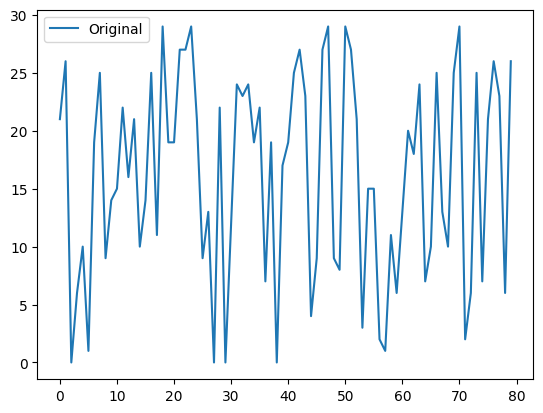

In [154]:
from scipy.interpolate import CubicSpline
inputImage = np.random.choice(range(30),(3,3,80))
spectra = inputImage[0,0,:]
spectra_indices = np.arange(0,len(spectra),1)
N=5
avg_spectra = [np.mean(spectra[i:i+N]) for i in range(0,len(spectra),N)]
avg_indices = [int(np.mean(np.arange(i,i+N,1))) for i in range(0,len(spectra),N)]
avg_err_y = [np.std(spectra[i:i+N]) for i in range(0,len(spectra),N)]
avg_err_x = [np.std(np.arange(i,i+N,1)) for i in range(0,len(spectra),N)]

plt.plot(spectra,label='Original')
# plt.plot(avg_indices,avg_spectra,label='Average')
# plt.errorbar(avg_indices,avg_spectra,yerr=avg_err_y,xerr=avg_err_x,fmt='.',color='black',capsize=5)
plt.legend()

def spline_func(averaged_spectrum_pixel):
    f = CubicSpline(avg_indices,averaged_spectrum_pixel)
    return f(spectra_indicies)

vfunc = np.vectorize(spline_func,excluded=["og_x","resample_x"],signature='(n)->(n)')
vfunc(inputImage)

spline = spline_func(avg_spectra,spectra_indices,avg_indices)

plt.plot(spectra_indices,spline,label='Cubic Spline')
plt.legend()

(4814, 304, 59)
(588352, 59)
-9999.0

Bright Points:
(2442, 19)
(532, 194)


Shadow Points Points:
(3826, 83)
(1514, 287)




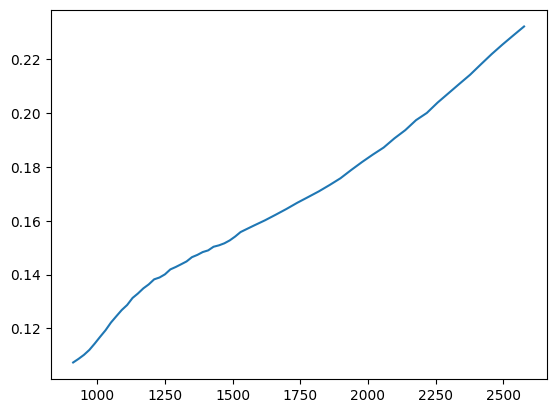

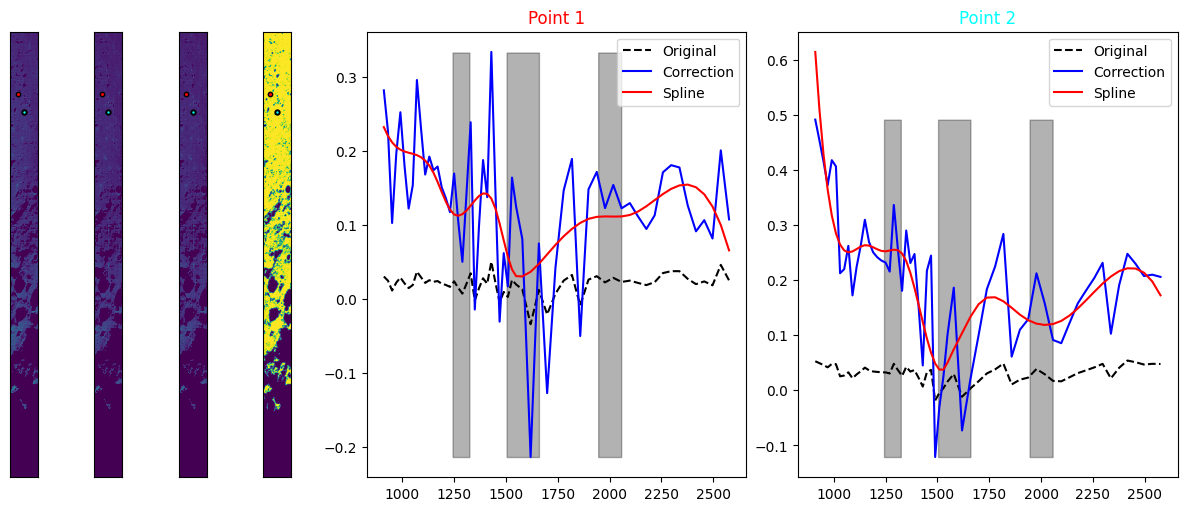

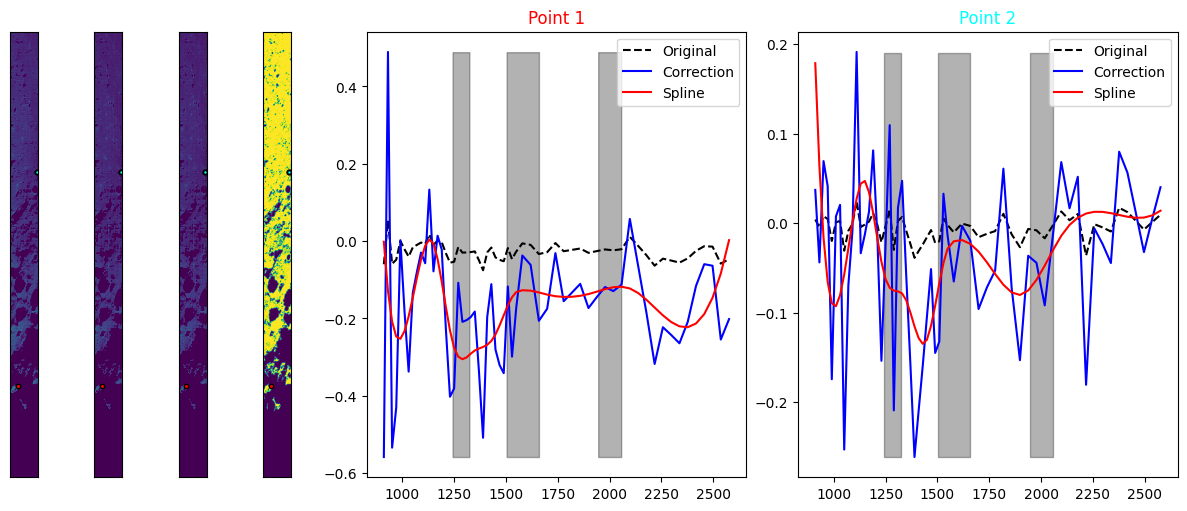

In [30]:
import tifffile as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy

wvl = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-14-23/bandInfo.csv').iloc[:,2]


im_id = '20090528t083319'
rfl_img = tf.imread(f'D:/Data/Ice_Pipeline_Out_6-14-23/rfl_cropped/m3g{im_id}_rfl_cropped.tif')
bool_array = tf.imread(f'D:/Data/Ice_Pipeline_Out_6-14-23/bright_bool_arrays/{im_id}_bright.tif')
R_BI = np.mean(np.load('D:/Data/Ice_Pipeline_Out_6-14-23/mosaic_stats_array.npy')[:,:,0],axis=0)
plt.plot(wvl,R_BI)
corrected_img = tf.imread(f'D:/Data/Ice_Pipeline_Out_6-14-23/rfl_correction/{im_id}_corrected.tif')
smooth_img = tf.imread(f'D:/Data/Ice_Pipeline_Out_6-14-23/rfl_smooth/{im_id}_smooth.tif')
rfl_img_real = copy.copy(rfl_img)
shaded_regions = rfl_img[np.where(bool_array==-9999)]
print (rfl_img.shape)
print (shaded_regions.shape)
shaded_regions_corrected = shaded_regions/R_BI
rfl_img[np.where(bool_array==-9999)] = shaded_regions_corrected

def get_spec(x,y):
    if x>rfl_img.shape[1] or y>rfl_img.shape[0]:
        raise ValueError(f'The point ({y},{x}) is not on the image of size {(rfl_img.shape[:2])}!')
    fig,axList = plt.subplots(1,6,figsize=(12,5),width_ratios=[1,1,1,1,5,5],constrained_layout=True)
    for num,ax in enumerate(axList):
        if num==4:
            break
        ax.set_yticks([])
        ax.set_xticks([])
    axList[0].imshow(rfl_img_real[:,:,0],vmax=rfl_img_real[:,:,0].max()*0.1,vmin=0.05)
    axList[1].imshow(rfl_img[:,:,0],vmax=rfl_img[:,:,0].max()*0.1,vmin=0.05)
    axList[2].imshow(corrected_img[:,:,0],vmax=corrected_img[:,:,0].max()*0.1,vmin=0.05)
    axList[3].imshow(bool_array)
    axList[4].plot(wvl,rfl_img_real[y,x,:],label='Original',ls='--',color='k')
    axList[4].plot(wvl,corrected_img[y,x,:],label='Correction',color='blue')
    axList[4].plot(wvl,smooth_img[y,x,:],label='Spline',color='red')
    for i,j in zip([1242,1503,1945],[1323,1659,2056]): 
        axList[4].fill_betweenx(np.arange(corrected_img[y,x,:].min(),corrected_img[y,x,:].max(),0.001),i,j,color='k',alpha=0.3)
    axList[4].set_title('Point 1',color='red')
    axList[4].legend()
    axList[0].scatter(x,y,marker='o',color='red',edgecolors='k',s=10)
    axList[1].scatter(x,y,marker='o',color='red',edgecolors='k',s=10)
    axList[2].scatter(x,y,marker='o',color='red',edgecolors='k',s=10)
    axList[3].scatter(x,y,marker='o',color='red',edgecolors='k',s=10)

    return fig,axList

def add_point(axList,x,y):
    axList[5].plot(wvl,rfl_img_real[y,x,:],label='Original',ls='--',color='k')
    axList[5].plot(wvl,corrected_img[y,x,:],label='Correction',color='blue')
    axList[5].plot(wvl,smooth_img[y,x,:],label='Spline',color='red')
    axList[5].set_title('Point 2',color='cyan')
    axList[5].legend()
    axList[0].scatter(x,y,marker='o',color='cyan',edgecolors='black',linewidth=1.4,s=10)
    axList[1].scatter(x,y,marker='o',color='cyan',edgecolors='black',linewidth=1.4,s=10)
    axList[2].scatter(x,y,marker='o',color='cyan',edgecolors='black',linewidth=1.4,s=10)
    axList[3].scatter(x,y,marker='o',color='cyan',edgecolors='black',linewidth=1.4,s=10)
    for i,j in zip([1242,1503,1945],[1323,1659,2056]): 
        axList[5].fill_betweenx(np.arange(corrected_img[y,x,:].min(),corrected_img[y,x,:].max(),0.001),i,j,color='k',alpha=0.3)

print (bool_array.min())
shade_coords = [(i,j) for i,j in zip(*(np.where(bool_array==-9999)))]
bright_coords = [(i,j) for i,j in zip(*(np.where(bool_array==1)))]
rand_ind1 = np.random.choice(range(len(shade_coords)))
rand_ind2 = np.random.choice(range(len(shade_coords)))
rand_ind1_bright = np.random.choice(range(len(bright_coords)))
rand_ind2_bright = np.random.choice(range(len(bright_coords)))
print ()
fig1,ax1 = get_spec(82,671)
add_point(ax1,152,864)
fig2,ax2 = get_spec(*reversed(shade_coords[rand_ind1]))
add_point(ax2,*reversed(shade_coords[rand_ind2]))
print(f'Bright Points:\n{bright_coords[rand_ind1_bright]}\n{bright_coords[rand_ind2_bright]}\n\n')
print(f'Shadow Points Points:\n{shade_coords[rand_ind1]}\n{shade_coords[rand_ind2]}\n\n')

29.631166


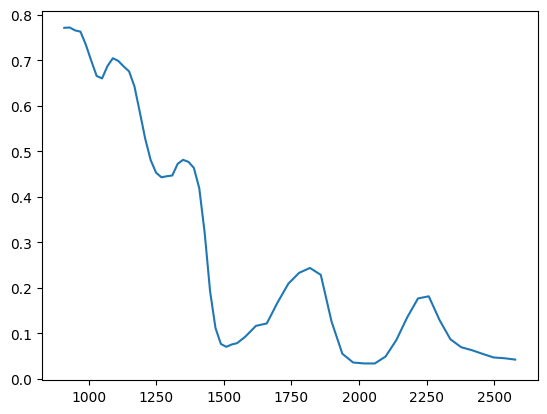

In [12]:
spec_ang = tf.imread('D:/Data/Ice_Pipeline_Out_6-14-23/spectral_angle_maps/20090528t083319_SAM.tif')
import get_USGS_H2OFrost
from importlib import reload
reload(get_USGS_H2OFrost)
from get_USGS_H2OFrost import get_USGS_H2OFrost
_wvl,usgs_spec = get_USGS_H2OFrost('D:/Data/USGS_Water_Ice',wvl)
print (spec_ang[147,15])
#plt.plot(wvl,smooth_img[147,15,:])
plt.plot(wvl,usgs_spec)

896 896
166.68477 16.820442
1443
166.68477 16.820442
0 1


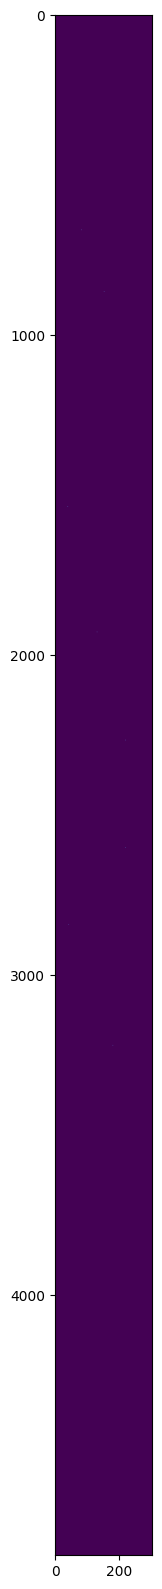

In [27]:
import tifffile as tf
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

im = tf.imread('D:/Data/Ice_Pipeline_Out_6-14-23/spectral_angle_maps/20090528t083319_SAM.tif')
water_loc = np.array(pd.read_csv('D:/Data/Ice_Pipeline_Out_6-14-23/water_locations/20090528t083319.csv').iloc[:,-2:]).astype(int)
x,y = (water_loc.T)

print (len(x),len(y))

bool_array = np.zeros(im.shape).astype(int)
bool_array[x,y] = 1

print (im.max(),im.min())
print (len(np.where(im<30)[0]))
bool_array[np.where(im>30)]=0
print (im.max(),im.min())
fig = plt.figure(figsize=(5,20))
plt.imshow(bool_array)

print (bool_array.min(),bool_array.max())

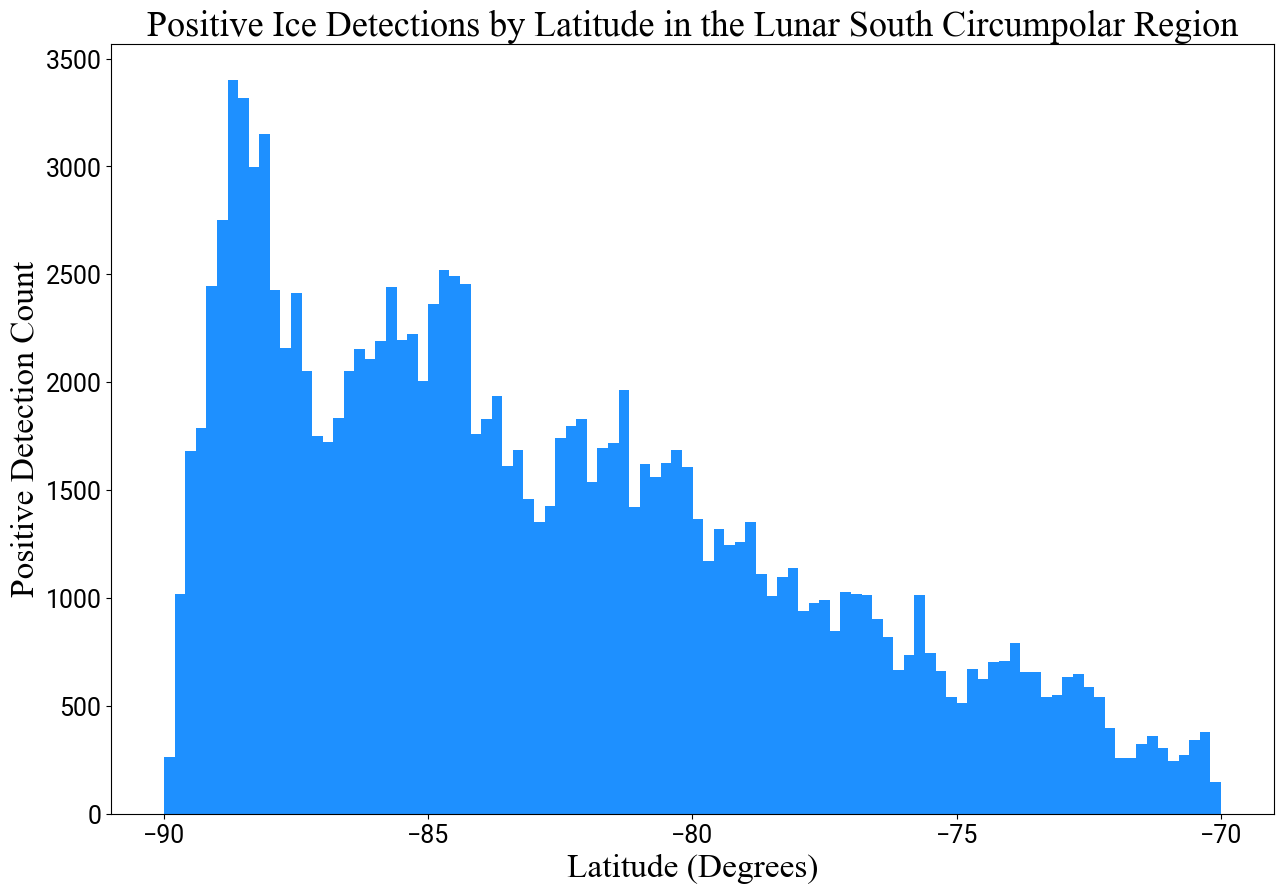

In [145]:
'''
Creating SCP Region Histogram of Water Detections vs. Latitude
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import os
import os.path as path

# pd.set_option('display.max_rows',None)

# flist = matplotlib.font_manager.get_font_names()
# flist.sort()
# fig = plt.figure()
# def factor(n):
#     return [(i,n//i) for i in range(1,int(n**0.5)+1) if n%i==0]

# print (factor(len(flist)))

# fig,ax = plt.subplots(1,1,figsize=(25,30))
# x,y = np.meshgrid(range(28),range(7))
# ax.set_xlim(-0.1,7)
# ax.set_ylim(-1,28.1)
# for i,j,font in zip(x.flatten(),y.flatten(),flist):
#     plt.text(j,i,font,fontdict={'fontname':font,'fontsize':14})

# plt.savefig('C:/Users/zvig/OneDrive - University of Iowa/Desktop/ALL_FONTS.png')



label_font = {'fontname':'Times New Roman','fontsize':24}
tick_font = {'fontname':'Roboto','fontsize':18}
title_font = {'fontname':'Times New Roman','fontsize':26}

all_detect = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-14-23/all_detections_30.csv')
fig = plt.figure(figsize=(15,10))
plt.hist(all_detect['Latitude'],100,color='dodgerblue')
plt.xlabel('Latitude (Degrees)',label_font)
plt.ylabel('Positive Detection Count',label_font)
plt.title('Positive Ice Detections by Latitude in the Lunar South Circumpolar Region',title_font)
plt.xticks(range(-90,-65,5),**tick_font)
plt.yticks(range(0,4000,500),**tick_font)

plt.savefig('D:/Ice_Locations_Figures/Ice_Locations_30SPA_Histogram.png',dpi=350)

In [2]:
'''
Getting average water spectra of all ice detections
'''
import tifffile as tf
import numpy as np
import pandas as pd
import os
import os.path as path
import time

all_detect = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-14-23/all_detections_30.csv')

with open('D:/Data/Ice_Pipeline_Out_6-14-23/stampNames.txt') as f:
    stampNames = f.readlines()
stampNames = [i[:-2] for i in stampNames]
# if 'smooth_images' not in locals():
#     print ('Fetching smoothed images from CPU...')
#     smooth_images = [tf.imread(path.join(smooth_image_folder_path,i)) for i in os.listdir(smooth_image_folder_path)]
# if 'raw_images' not in locals():
#     print ('Fetching raw images from CPU...')
#     raw_images = [tf.imread(path.join(raw_image_folder_path,i)) for i in os.listdir(raw_image_folder_path)]

#print (f'{len(smooth_images)} Smoothed Images and {len(raw_images)} Raw Images have been loaded!')

all_spectra_array = np.zeros((0,59))
all_raw_array = np.zeros((0,59))
for i in range(0,len(smooth_images)):
    x,y = (np.array(all_detect.loc[all_detect['Stamp_Num']==i+1][['x','y']]).astype(int).T)
    detections = smooth_images[i][x,y]
    detections_raw = corrected_images[i][x,y]
    all_spectra_array = np.concatenate([all_spectra_array,detections])
    all_raw_array = np.concatenate([all_raw_array,detections_raw])

print (all_spectra_array.shape)
print (all_raw_array.shape)



(136326, 59)
(136326, 59)


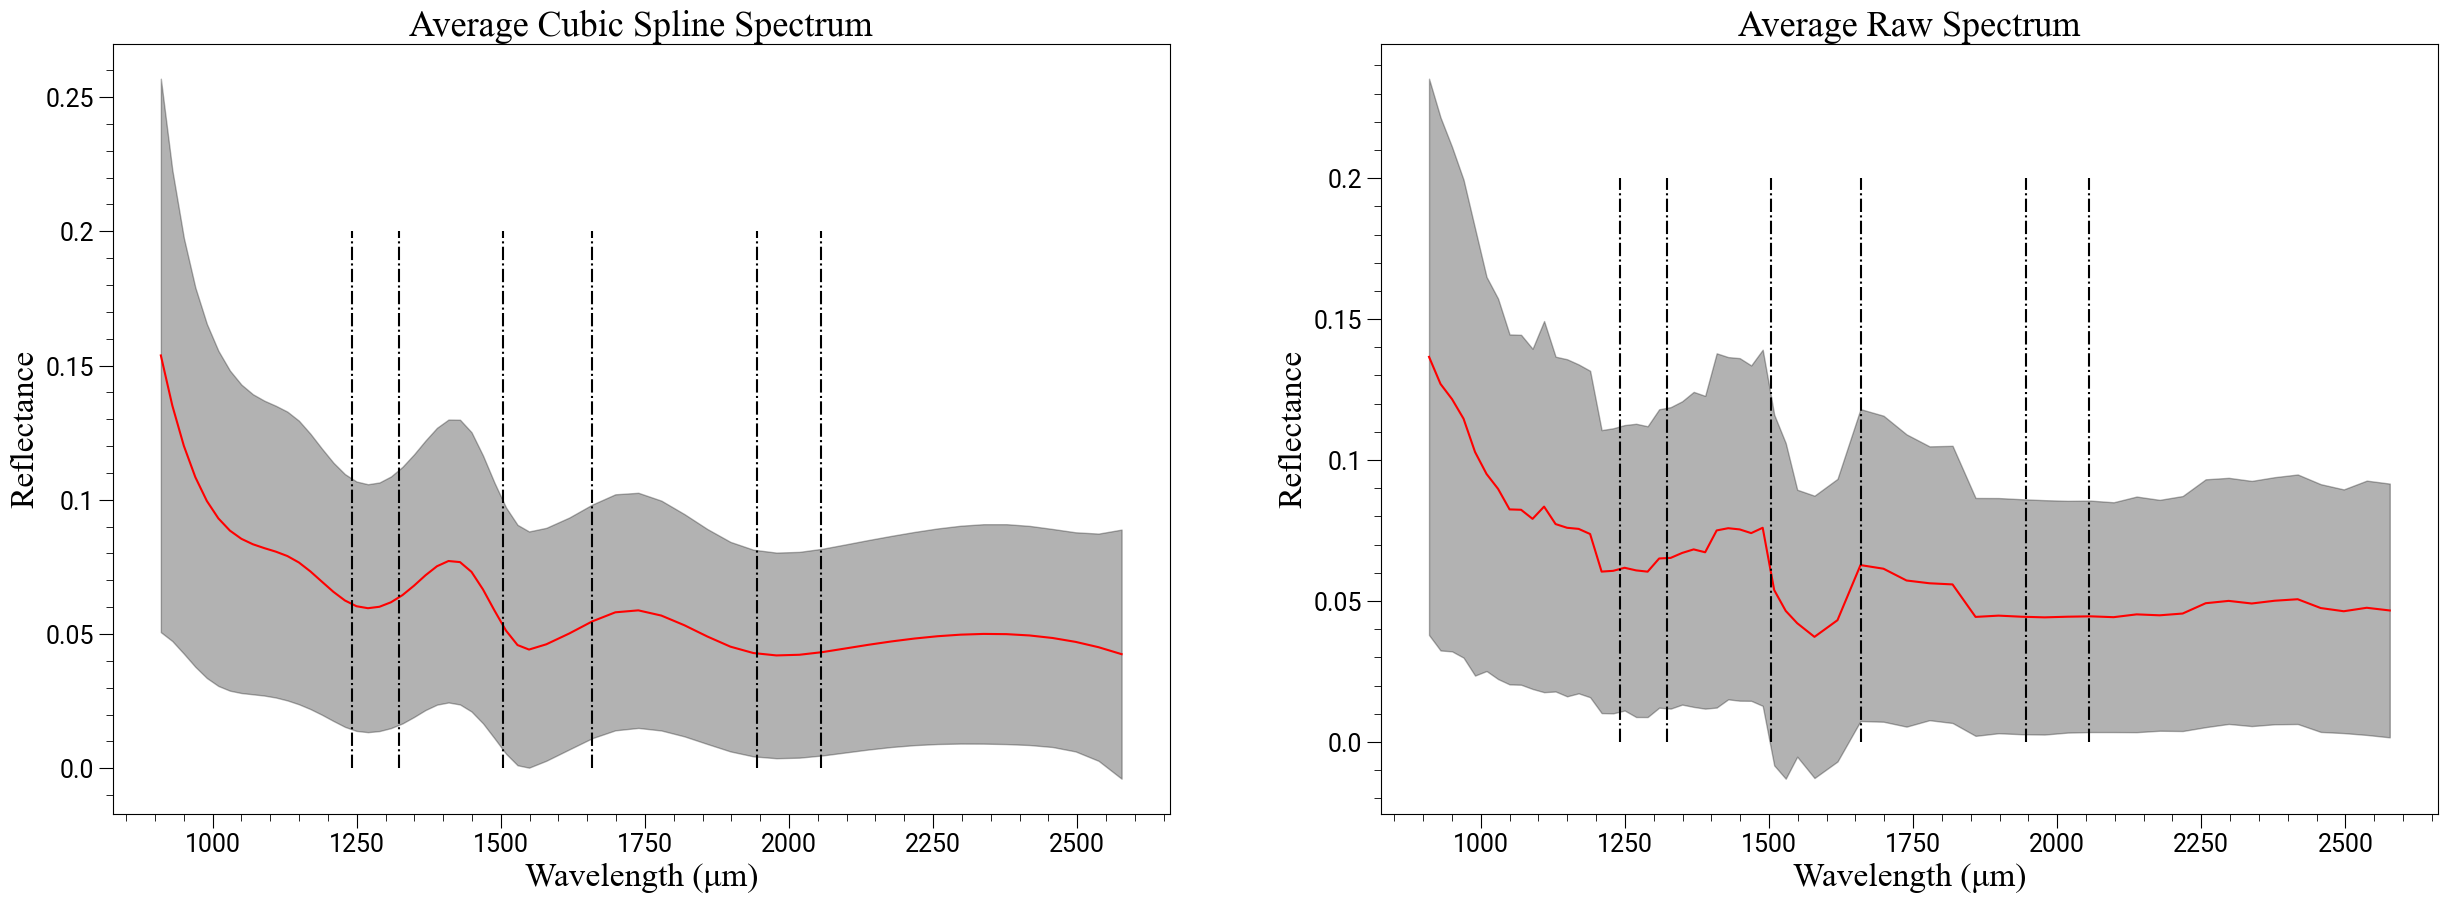

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

label_font = {'fontname':'Times New Roman','fontsize':24}
tick_font = {'fontname':'Roboto','fontsize':18}
title_font = {'fontname':'Times New Roman','fontsize':26}

wvl = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-14-23/bandInfo.csv').iloc[:,2]
avg_smooth_spec = np.mean(all_spectra_array,axis=0)
std_smooth_spec = np.std(all_spectra_array,axis=0)
avg_raw_spec = np.mean(all_raw_array,axis=0)
std_raw_spec = np.std(all_raw_array,axis=0)

fig,axList = plt.subplots(1,2,figsize=(30,10))
axList[0].plot(wvl,avg_smooth_spec,color='red')
axList[0].fill_between(wvl,avg_smooth_spec-std_smooth_spec,avg_smooth_spec+std_smooth_spec,color='k',alpha=0.3)
axList[0].set_title('Average Cubic Spline Spectrum',title_font)
axList[0].set_yticks(np.arange(0,0.3,0.05),np.around(np.arange(0,0.3,0.05),2),**tick_font)
axList[0].yaxis.set_minor_locator(tck.MultipleLocator(0.01))
for lo,hi in zip([1242,1503,1945],[1323,1659,2056]):
    axList[0].vlines([lo,hi],0,0.2,color='k',ls='dashdot')

axList[1].plot(wvl,avg_raw_spec,color='red')
axList[1].fill_between(wvl,avg_raw_spec-std_raw_spec,avg_raw_spec+std_raw_spec,color='k',alpha=0.3)
axList[1].set_title('Average Raw Spectrum',title_font)
axList[1].set_yticks(np.arange(0,0.3,0.05),np.around(np.arange(0,0.3,0.05),2),**tick_font)
axList[1].yaxis.set_minor_locator(tck.MultipleLocator(0.01))
for lo,hi in zip([1242,1503,1945],[1323,1659,2056]):
    axList[1].vlines([lo,hi],0,0.2,color='k',ls='dashdot')

for ax in axList:
    ax.set_xticks(range(1000,2750,250),range(1000,2750,250),**tick_font)
    ax.set_xlabel('Wavelength (\u03Bcm)',label_font)
    ax.set_ylabel('Reflectance',label_font)
    ax.xaxis.set_minor_locator(tck.MultipleLocator(50))
    ax.tick_params(length=10)
    ax.tick_params('both',which='minor',length=5)

#plt.savefig('D:/Ice_Locations_Figures/Mean_Spec_30SPA.png',dpi=400)
    

In [1]:
import os
import os.path as path
import tifffile as tf
smooth_image_folder_path = 'D:/Data/Ice_Pipeline_Out_6-14-23/rfl_smooth'
raw_image_folder_path = 'D:/Data/Ice_Pipeline_Out_6-14-23/rfl_correction'
print ('Fetching smoothed images from CPU...')
smooth_images = [tf.imread(path.join(smooth_image_folder_path,i)) for i in os.listdir(smooth_image_folder_path)]
print ('Fetching raw images from CPU...')
corrected_images = [tf.imread(path.join(raw_image_folder_path,i)) for i in os.listdir(raw_image_folder_path)]

Fetching smoothed images from CPU...
Fetching raw images from CPU...
